# Import Libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Custom Dataset Class

In [2]:
class Dataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

# Transformation and Instantiate Data Loader

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

In [4]:
dataset = Dataset(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Generator & Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #embedding layer with 10 possible classes and a 10-dimensional embedding vector for each class.
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        
        return out.view(x.size(0), 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        
        return out.squeeze()

# Instantiate Generator & Discriminator

In [7]:
gen = Generator().cuda()
disc = Discriminator().cuda()

# Instantiate Loss Function & Optimizers

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

# Training

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0, g_loss: 0.8626296520233154, d_loss: 1.5368001461029053


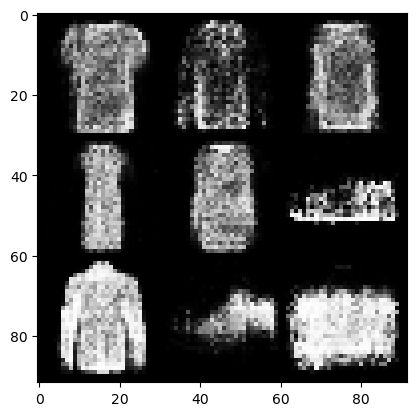

Epoch: 10, g_loss: 1.1261059045791626, d_loss: 1.0425031185150146


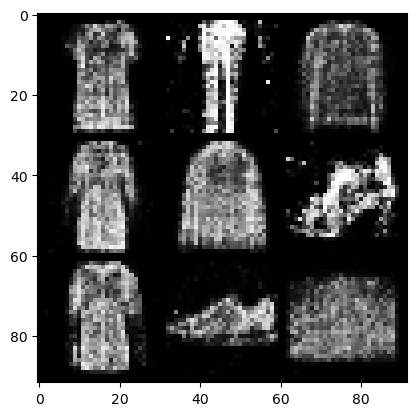

Epoch: 20, g_loss: 1.0627092123031616, d_loss: 1.3318513631820679


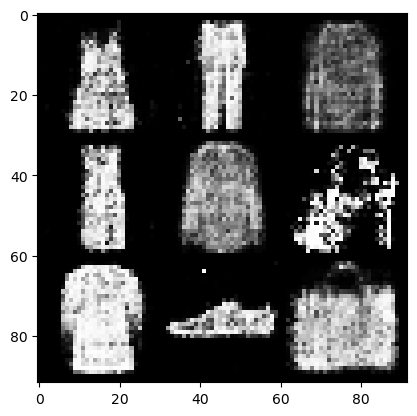

In [11]:
num_epochs = 30
n_critic = 5
display_step = 300

for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        gen.train()
        batch_size = real_images.size(0)
        
        d_optimizer.zero_grad()

        # train with real images
        real_validity = disc(real_images, labels)
        real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

        # train with fake images
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_images = gen(z, fake_labels)
        fake_validity = disc(fake_images, fake_labels)
        fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_images = gen(z, fake_labels)
        validity = disc(fake_images, fake_labels)
        g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
        g_loss.backward()
        g_optimizer.step()
        
    gen.eval()
    
    if(epoch%10==0):
        print('Epoch: {}, g_loss: {}, d_loss: {}'.format(epoch, g_loss, d_loss))
        z = Variable(torch.randn(9, 100)).cuda()
        labels = Variable(torch.LongTensor(np.arange(9))).cuda()
        sample_images = gen(z, labels).unsqueeze(1).data.cpu()
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

# Generate

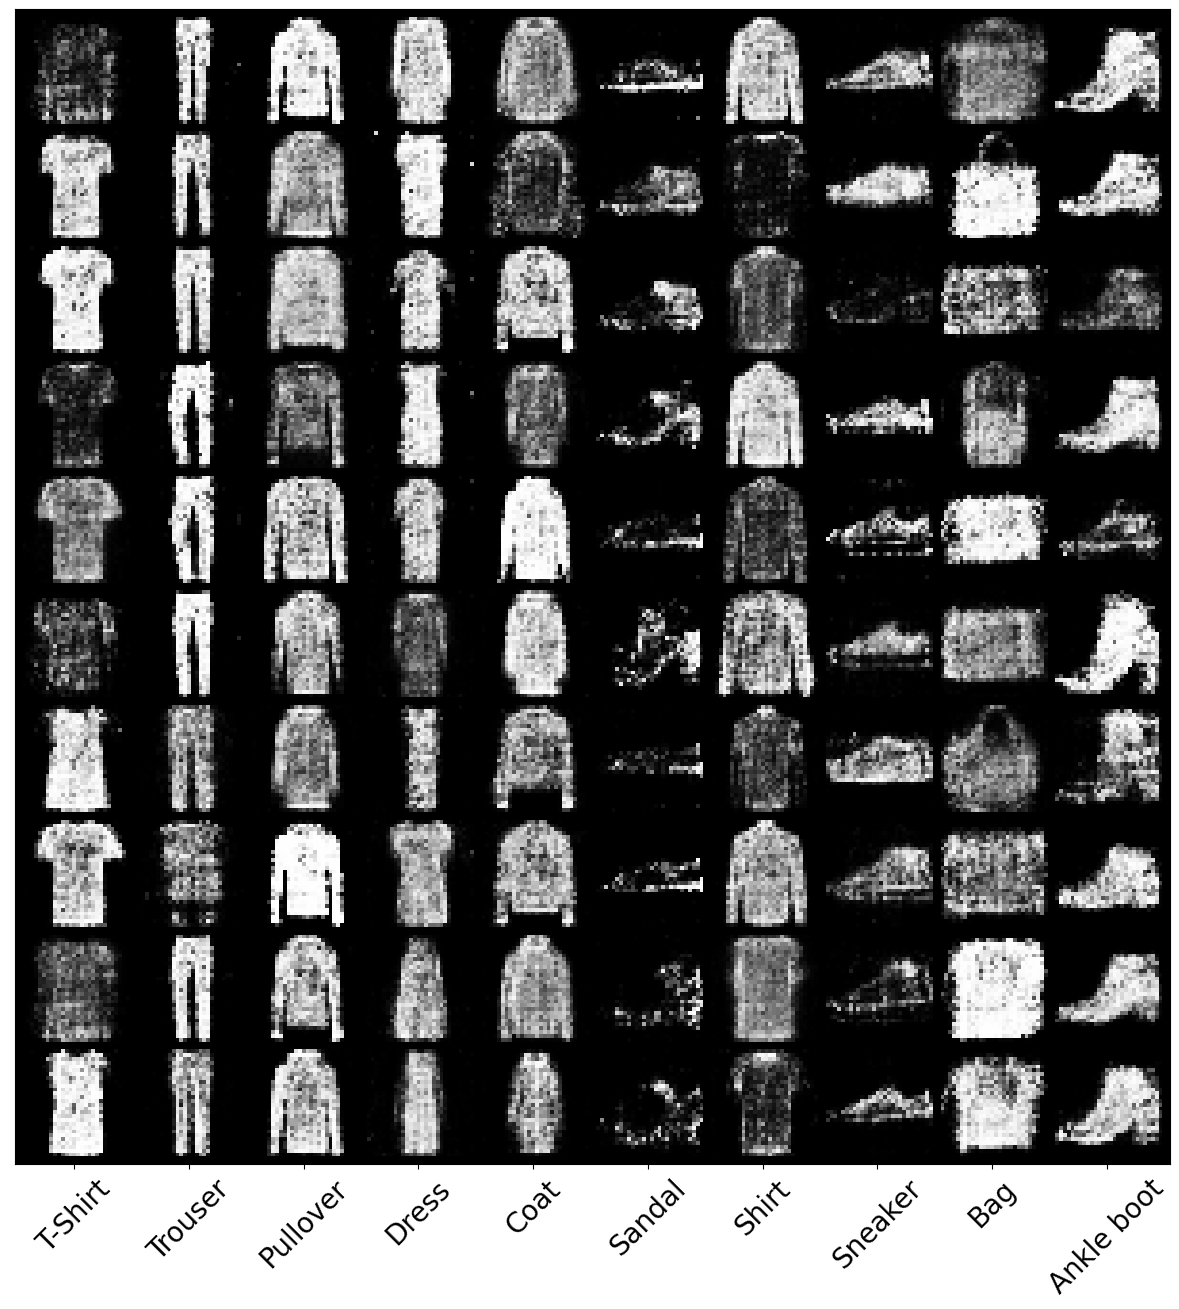

In [12]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = gen(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)